In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

In [2]:
system = 'cartesius'
df = pd.read_parquet(f'data/mpi/{system}/{system}_interval.gzip')

In [4]:
functions = [
    'mpi_allgather',
    'mpi_allreduce',
    'mpi_bcast',
    'mpi_gather'
]
metric = 'inc_time'
nodes = nodes = [8, 16, 32, 48] if system == 'cartesius' else [1, 4, 8]
gpus = 2 

df_atomic = df[
    (df['workers'] == 2) &
    (df['gpus_per_node'] == (2 if system == 'cartesius' else 4)) &
    (df['data_loader'] == 'dali-cpu-to-gpu') &
    (df['grad_precision'] == 'fp32') &
    (df['batch_size_per_gpu'] == 32)
]

data_atomic = defaultdict(list)

for f in functions:
    for node in nodes:
        if system == 'cartesius':
            gpus_per_node = [2] if node != 1 else [1, 2]
        else:
            gpus_per_node = [4] if node != 1 else [4]
        for gpu in gpus_per_node:
            n = []
            for run in range(10):
                d = df_atomic[
                    (df_atomic['nodes'] == node) & 
                    (df_atomic['function'] == f) & 
                    (df_atomic['run'] == run) &
                    (df_atomic['gpus_per_node'] == gpu)
                ][metric].values
                n.append(np.sum(d))
            data_atomic[f].append(n)


allgather = [np.mean(np.array(d)) for d in data_atomic['mpi_allgather']]
allreduce = [np.mean(np.array(d)) for d in data_atomic['mpi_allreduce']]
broadcast = [np.mean(np.array(d)) for d in data_atomic['mpi_bcast']]
gather = [np.mean(np.array(d)) for d in data_atomic['mpi_gather']]

allgather_err = [np.std(np.array(d)) for d in data_atomic['mpi_allgather']]
allreduce_err = [np.std(np.array(d)) for d in data_atomic['mpi_allreduce']]
broadcast_err = [np.std(np.array(d)) for d in data_atomic['mpi_bcast']]
gather_err = [np.std(np.array(d)) for d in data_atomic['mpi_gather']]


In [6]:
def conf_interval(data, alpha=5.0):
    lower_p = alpha / 2.0
    upper_p = (100 - alpha) + (alpha / 2.0)
    return np.abs(np.median(data) - np.array([np.percentile(data, lower_p), np.percentile(data, upper_p)]))

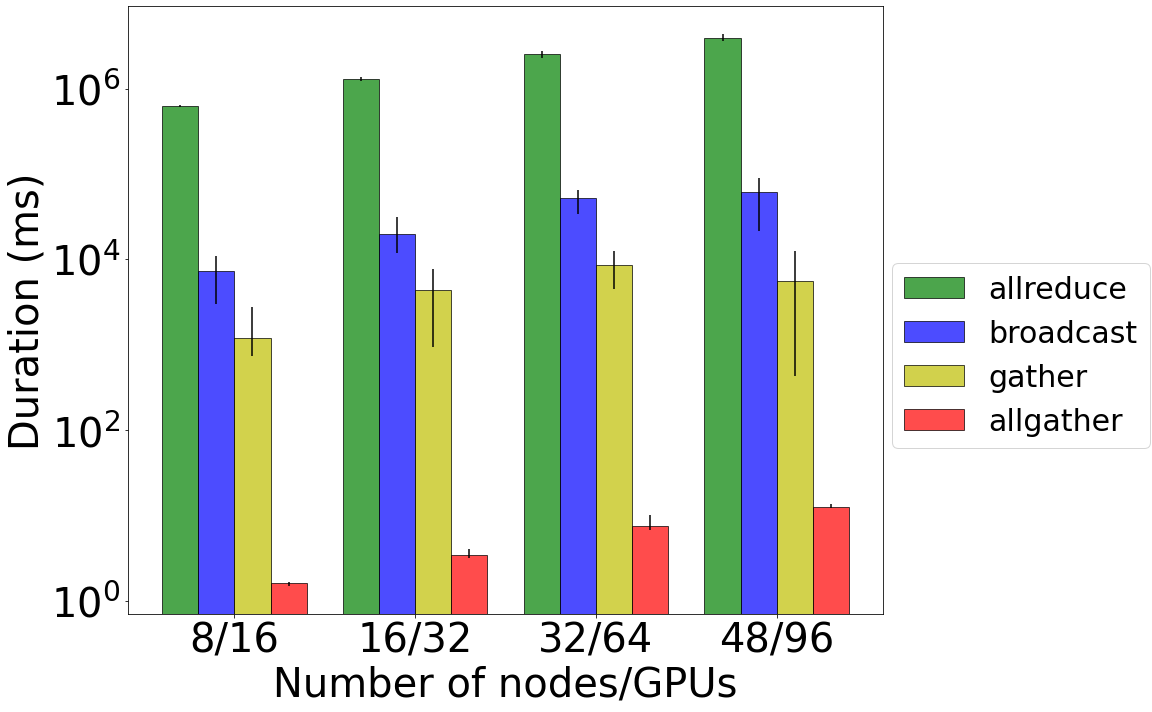

In [7]:
from cycler import cycler
default_cycler = (cycler(color=['g', 'b', 'y', 'r']))

allgather = [np.median(np.array(d)*1e-3) for d in data_atomic['mpi_allgather']]
allreduce = [np.median(np.array(d)*1e-3) for d in data_atomic['mpi_allreduce']]
broadcast = [np.median(np.array(d)*1e-3) for d in data_atomic['mpi_bcast']]
gather = [np.median(np.array(d)*1e-3) for d in data_atomic['mpi_gather']]

allgather_err = np.array([conf_interval(np.array(d)*1e-3) for d in data_atomic['mpi_allgather']]).T
allreduce_err = np.array([conf_interval(np.array(d)*1e-3) for d in data_atomic['mpi_allreduce']]).T
broadcast_err = np.array([conf_interval(np.array(d)*1e-3) for d in data_atomic['mpi_bcast']]).T
gather_err = np.array([conf_interval(np.array(d)*1e-3) for d in data_atomic['mpi_gather']]).T

ind = np.arange(len(allreduce))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
ax.set_prop_cycle(default_cycler)

fig.set_size_inches(16, 10)

b1 = ax.bar(ind - 3*width/2, allreduce, width, yerr=allreduce_err ,label='allreduce', edgecolor='black', alpha=0.7)
b2 = ax.bar(ind - width/2, broadcast, width, yerr=broadcast_err ,label='broadcast', edgecolor='black', alpha=0.7)
b3 = ax.bar(ind + width/2, gather, width, yerr=gather_err ,label='gather', edgecolor='black', alpha=0.7)
b4 = ax.bar(ind + 3*width/2, allgather, width, yerr=allgather_err ,label='allgather', edgecolor='black', alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Duration (ms)', fontsize=40)
plt.yscale('log')
ax.set_xticks(ind)
ax.set_xticklabels([f"{node}/{node*2}" if system == 'cartesius' else f"{node}/{node*4}" for node in nodes])
ax.set_xlabel('Number of nodes/GPUs', fontsize=40)

ax.set_yticks([1, 100, 10000, 1000000])
ax.tick_params(axis='both', which='major', labelsize=40)
fig.legend(loc='center right',  borderaxespad=0.1, fontsize=30)
plt.tight_layout()
plt.subplots_adjust(right=0.77, wspace=0.25)

# Atomic Data

In [17]:
system = 'lisa'
df = pd.read_parquet(f'data/mpi/{system}/{system}_atomic.gzip')

In [18]:
df['volume'] = df['num_samples'] * df['mean'] 

In [19]:
df

,run,nodes,gpus_per_node,network_backend,profile_level,workers,neural_network,data_loader,batch_size_per_gpu,grad_precision,compute_precision,gpu,thread,function,num_samples,max,min,mean,volume
0,0,1,1,eth,tau_exec,2,resnet50,dali-cpu-to-gpu,32,fp16,fp32,0,0,Message size for all-gather,0,0,0,0.0,0.0
1,0,1,1,eth,tau_exec,2,resnet50,dali-cpu-to-gpu,32,fp16,fp32,0,0,Message size for all-reduce,0,0,0,0.0,0.0
2,0,1,1,eth,tau_exec,2,resnet50,dali-cpu-to-gpu,32,fp16,fp32,0,1,Message size for all-gather,2,4,4,4.0,8.0
3,0,1,1,eth,tau_exec,2,resnet50,dali-cpu-to-gpu,32,fp16,fp32,0,1,Message size for all-reduce,12868,8,8,8.0,102944.0
4,0,1,1,eth,tau_exec,2,resnet50,dali-cpu-to-gpu,32,fp16,fp32,0,2,Message size for all-gather,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905735,9,8,4,eth,tau_exec,4,resnet50,dali-gpu,64,fp32,fp32,31,34,Message size for all-reduce,0,0,0,0.0,0.0
905736,9,8,4,eth,tau_exec,4,resnet50,dali-gpu,64,fp32,fp32,31,34,Message size for broadcast,0,0,0,0.0,0.0
905737,9,8,4,eth,tau_exec,4,resnet50,dali-gpu,64,fp32,fp32,31,35,Message size for all-gather,0,0,0,0.0,0.0
905738,9,8,4,eth,tau_exec,4,resnet50,dali-gpu,64,fp32,fp32,31,35,Message size for all-reduce,0,0,0,0.0,0.0


In [20]:
functions = ['Message size for all-gather', 'Message size for all-reduce', 'Message size for broadcast', 'Message size for gather']
metric = 'num_samples'
nodes = nodes = [8, 16, 32, 48] if system == 'cartesius' else [1, 4, 8]

df_atomic = df[
    (df['workers'] == 2) &
    (df['gpus_per_node'] == (2 if system == 'cartesius' else 4)) &
    (df['data_loader'] == 'dali-cpu-to-gpu') &
    (df['grad_precision'] == 'fp32') &
    (df['batch_size_per_gpu'] == 32)
]
df_atomic = df_atomic[['nodes', 'gpus_per_node', 'run', 'gpu', 'thread', 'function', 'num_samples', 'max', 'min', 'mean', 'volume']]

data_atomic = defaultdict(list)

for f in functions:
    for node in nodes:
        if system == 'cartesius':
            gpus_per_node = [2] if node != 1 else [1, 2]
        else:
            gpus_per_node = [4] if node != 1 else [4]
        for gpu in gpus_per_node:
            n = []
            for run in range(10):
                d = df_atomic[
                    (df_atomic['nodes'] == node) & 
                    (df_atomic['function'] == f) & 
                    (df_atomic['run'] == run) &
                    (df_atomic['gpus_per_node'] == gpu)
                ][metric].values
                n.append(np.sum(d))
            data_atomic[f].append(n)


allgather = [np.median(np.array(d)) for d in data_atomic['Message size for all-gather']]
allreduce = [np.median(np.array(d)) for d in data_atomic['Message size for all-reduce']]
broadcast = [np.median(np.array(d)) for d in data_atomic['Message size for broadcast']]
gather = [np.median(np.array(d)) for d in data_atomic['Message size for gather']]

allgather_err = np.array([conf_interval(np.array(d)) for d in data_atomic['Message size for all-gather']]).T
allreduce_err = np.array([conf_interval(np.array(d)) for d in data_atomic['Message size for all-reduce']]).T
broadcast_err = np.array([conf_interval(np.array(d)) for d in data_atomic['Message size for broadcast']]).T
gather_err = np.array([conf_interval(np.array(d)) for d in data_atomic['Message size for gather']]).T


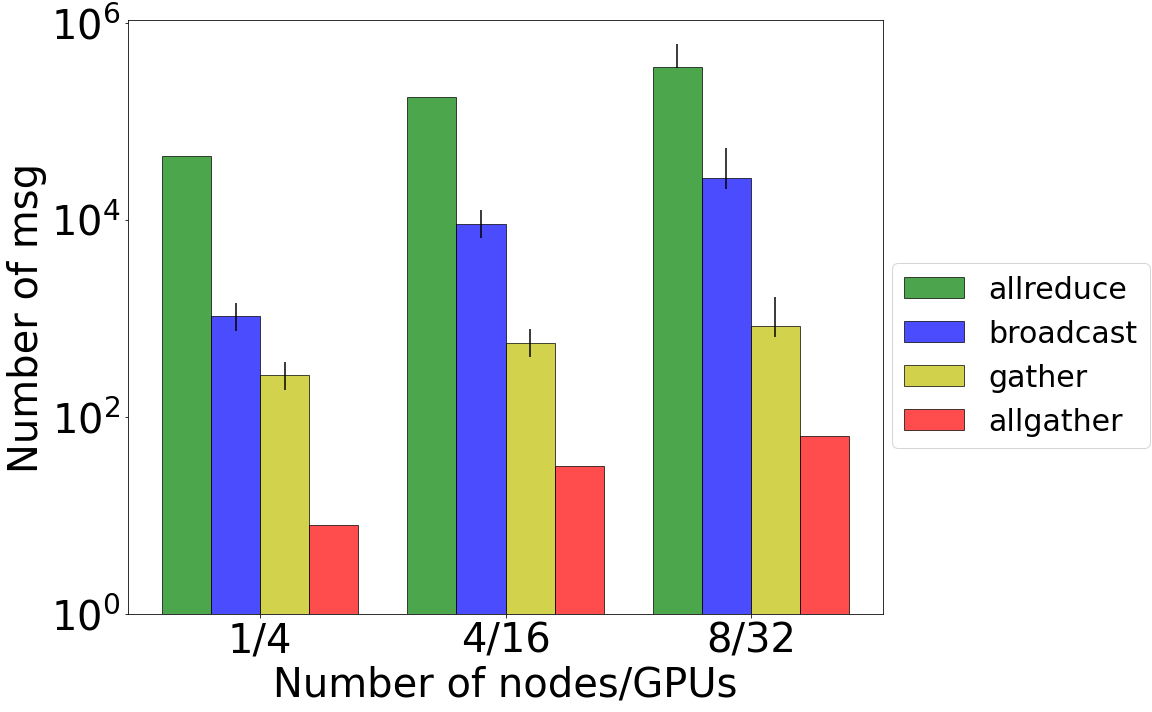

In [21]:
from cycler import cycler
default_cycler = (cycler(color=['g', 'b', 'y', 'r']))

ind = np.arange(len(allreduce))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots()

ax.set_prop_cycle(default_cycler)
fig.set_size_inches(16, 10)
b1 = ax.bar(ind - 3*width/2, allreduce, width, yerr=allreduce_err ,label='allreduce', edgecolor='black', alpha=0.7)
b2 = ax.bar(ind - width/2, broadcast, width, yerr=broadcast_err ,label='broadcast', edgecolor='black', alpha=0.7)
b3 = ax.bar(ind + width/2, gather, width, yerr=gather_err ,label='gather', edgecolor='black', alpha=0.7)
b4 = ax.bar(ind + 3*width/2, allgather, width, yerr=allgather_err ,label='allgather', edgecolor='black', alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of msg', fontsize=40)
plt.yscale('log')
ax.set_xticks(ind)
ax.set_xticklabels([f"{node}/{node*2}" if system == 'cartesius' else f"{node}/{node*4}" for node in nodes])
ax.set_xlabel('Number of nodes/GPUs', fontsize=40)
ax.set_yticks([1, 100, 10000, 1000000])
ax.tick_params(axis='both', which='major', labelsize=40)

fig.legend(loc='center right',  borderaxespad=0.1, fontsize=30)
plt.tight_layout()
plt.subplots_adjust(right=0.77, wspace=0.25)
# plt.savefig(f"images/{system}_number_messages.png")

In [22]:
functions = ['Message size for all-gather', 'Message size for all-reduce', 'Message size for broadcast', 'Message size for gather']
metric = 'volume'
nodes = nodes = [8, 16, 32, 48] if system == 'cartesius' else [1, 4, 8]

df_atomic = df[
    (df['workers'] == 2) &
    (df['gpus_per_node'] == (2 if system == 'cartesius' else 4)) &
    (df['data_loader'] == 'dali-cpu-to-gpu') &
    (df['grad_precision'] == 'fp32') &
    (df['batch_size_per_gpu'] == 32)
]
df_atomic = df_atomic[['nodes', 'gpus_per_node', 'run', 'gpu', 'thread', 'function', 'num_samples', 'max', 'min', 'mean', 'volume']]

data_atomic = defaultdict(list)

for f in functions:
    for node in nodes:
        if system == 'cartesius':
            gpus_per_node = [2] if node != 1 else [1, 2]
        else:
            gpus_per_node = [4] if node != 1 else [4]
        for gpu in gpus_per_node:
            n = []
            for run in range(10):
                d = df_atomic[
                    (df_atomic['nodes'] == node) & 
                    (df_atomic['function'] == f) & 
                    (df_atomic['run'] == run) &
                    (df_atomic['gpus_per_node'] == gpu)
                ][metric].values
                n.append(np.sum(d))
            data_atomic[f].append(n)


allgather = [np.median(np.array(d)) for d in data_atomic['Message size for all-gather']]
allreduce = [np.median(np.array(d)) for d in data_atomic['Message size for all-reduce']]
broadcast = [np.median(np.array(d)) for d in data_atomic['Message size for broadcast']]
gather = [np.median(np.array(d)) for d in data_atomic['Message size for gather']]

allgather_err = np.array([conf_interval(np.array(d)) for d in data_atomic['Message size for all-gather']]).T
allreduce_err = np.array([conf_interval(np.array(d)) for d in data_atomic['Message size for all-reduce']]).T
broadcast_err = np.array([conf_interval(np.array(d)) for d in data_atomic['Message size for broadcast']]).T
gather_err = np.array([conf_interval(np.array(d)) for d in data_atomic['Message size for gather']]).T


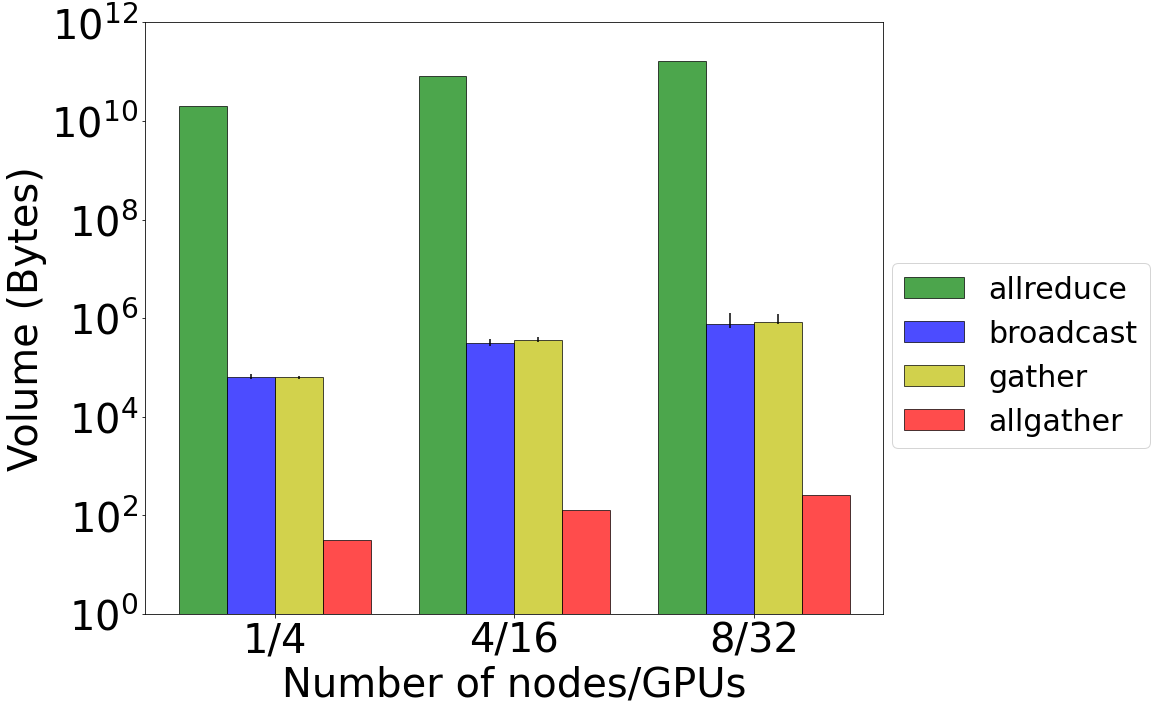

In [23]:
from cycler import cycler
default_cycler = (cycler(color=['g', 'b', 'y', 'r']))

ind = np.arange(len(allreduce))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots()

ax.set_prop_cycle(default_cycler)
fig.set_size_inches(16, 10)

b1 = ax.bar(ind - 3*width/2, allreduce, width, yerr=allreduce_err ,label='allreduce', edgecolor='black', alpha=0.7)
b2 = ax.bar(ind - width/2, broadcast, width, yerr=broadcast_err ,label='broadcast', edgecolor='black', alpha=0.7)
b3 = ax.bar(ind + width/2, gather, width, yerr=gather_err ,label='gather', edgecolor='black', alpha=0.7)
b4 = ax.bar(ind + 3*width/2, allgather, width, yerr=allgather_err ,label='allgather', edgecolor='black', alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Volume (Bytes)', fontsize=40)
plt.yscale('log')
ax.set_xticks(ind)
ax.set_xticklabels([f"{node}/{node*2}" if system == 'cartesius' else f"{node}/{node*4}" for node in nodes])
ax.set_xlabel('Number of nodes/GPUs', fontsize=40)
ax.set_yticks([1, 100, 10000, 1000000, 100000000, 10000000000, 1000000000000])
ax.tick_params(axis='both', which='major', labelsize=40)



fig.legend(loc='center right',  borderaxespad=0.1, fontsize=30)
# ax.legend(fontsize=40)
plt.tight_layout()
plt.subplots_adjust(right=0.77, wspace=0.25)
# plt.savefig(f"images/{system}_volume.png")